# Traditional Market, crypto market and legislative authorities 
----

## 1. Installation

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.2-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.2-bin-hadoop3.tgz
!pip install findspark

--2023-02-19 18:02:30--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘./spark-3.3.2-bin-hadoop3.tgz’

./spark-3.3.2-bin-h 100%[===================>] 285.49M   549MB/s    in 0.5s    

2023-02-19 18:02:31 (549 MB/s) - ‘./spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [2]:
!pip install pyspark-dbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

In [4]:
#setting up Kaggle
!pip install kaggle
import json

!mkdir /root/.kaggle/
!mv .kaggle /root/
import os

# Installing the Kaggle package
import findspark
import random
findspark.init()

import pyspark
from pyspark.sql import SparkSession, types, functions
from datetime import datetime
import datetime
from dateutil.parser import parse

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
#api_token = {"username":"<Insert Your Kaggle User Name>","key":"<Insert Your Kaggle API key>"}
api_token = {"username":"kiliemahouattara","key":"52190173370a1d098d932dca433f9304"}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mv: cannot stat '.kaggle': No such file or directory


## 2. PySpark test

Let's start checking if PySpark works by running the following code that calculates $\pi$:

In [5]:
# SparkContext  is the entry point to the services of Apache Spark (execution engine) 
sc = pyspark.SparkContext("local", appName="CalcPi")
def inside(p):
    x, y = random.random(), random.random()
    return x*x + y*y < 1

NUM_SAMPLES  = 1000000
count = sc.parallelize(range(0, NUM_SAMPLES)) \
             .filter(inside).count()
print(f"Pi is roughly {(4.0 * count / NUM_SAMPLES)}")

sc.stop()

Pi is roughly 3.139632


## 3. Data collection

**Data links :**
> S&P 500 data: https://www.kaggle.com/datasets/myungchankim/sp-500-daily-data-19281230-to-20210919
<br> US congres investments: https://www.kaggle.com/datasets/heresjohnnyv/congress-investments <br>
> bitcoin data: https://www.kaggle.com/datasets/varpit94/bitcoin-data-updated-till-26jun2021

In [6]:
import kaggle
!mkdir ./datasets
!mkdir ./datasets/dickens

# Authenticate with Kaggle
kaggle.api.authenticate()

# Download the dataset
kaggle.api.dataset_download_files('myungchankim/sp-500-daily-data-19281230-to-20210919', path='./datasets/', unzip=True)
kaggle.api.dataset_download_files('heresjohnnyv/congress-investments', path='./datasets/', unzip=True)
kaggle.api.dataset_download_files('varpit94/bitcoin-data-updated-till-26jun2021', path='./datasets/', unzip=True)

mkdir: cannot create directory ‘./datasets’: File exists
mkdir: cannot create directory ‘./datasets/dickens’: File exists


In [7]:
#Storing dataset path
spx_path = "./datasets/SPX_500_Data.csv"
btc_path = "./datasets/BTC-USD.csv"
authorities_path = "./datasets/SenatorCleaned.csv"

#Creating SparkContext object connected to the localhost
sc = pyspark.SparkContext("local", appName="Market&Authorities")

In [8]:
#Creating spark session
spark = SparkSession.builder.appName("Market&Authorities").getOrCreate()

# Read the 3 CSV files into 3 DataFrames
spx_df = spark.read.csv(spx_path, header=True, inferSchema=True)
btc_df = spark.read.csv(btc_path, header=True, inferSchema=True)
authorities_df = spark.read.csv(authorities_path, header=True, inferSchema=True, sep=',',  multiLine=True)\
        .withColumnRenamed('_c0', 'Index')\
        .withColumnRenamed('Transaction.Date', 'Date')\
        .withColumnRenamed('Asset.Name', 'Asset_Name')\
        .withColumnRenamed('Asset.Type', 'Asset_Type')\
        .withColumnRenamed('Type', 'Transaction_Type')


## 4. Data preprocessing

### 4.1. Schema processing

In [9]:
# Preprocessing S&P 500 historical data

# reformationg S&P 500 date column
spx_df = spx_df.withColumn("Date", functions.to_date(spx_df["Date"], 'yyyy-MM-dd'))

# Displaying S&P 500 historical data
spx_df.printSchema()
spx_df.show()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)
 |-- % Gain/Loss (Close): double (nullable = true)
 |-- % Price Variation: double (nullable = true)

+----------+-----+-----+-----+-----+---------+------+-------------------+-----------------+
|      Date| Open| High|  Low|Close|Adj Close|Volume|% Gain/Loss (Close)|% Price Variation|
+----------+-----+-----+-----+-----+---------+------+-------------------+-----------------+
|1927-12-30|17.66|17.66|17.66|17.66|    17.66|     0|                0.0|              0.0|
|1928-01-03|17.76|17.76|17.76|17.76|    17.76|     0|             0.5631|              0.0|
|1928-01-04|17.72|17.72|17.72|17.72|    17.72|     0|            -0.2257|              0.0|
|1928-01-05|17.55|17.55|17.55|17.55|    17.55|     0|            -0.9687|              

In [10]:
# Preprocessing American congress members investment dataset

# It seems that even with the inferSchema some columns(Date, Amount) have the wrong type
# In the following code we are changing these columns types
authorities_df = authorities_df.withColumn("Amount", authorities_df["Amount"].cast("integer"))
authorities_df = authorities_df.withColumn("Date", functions.to_date(authorities_df["Date"], 'M/d/yyyy'))

authorities_df.printSchema()
authorities_df.show()

root
 |-- Index: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Asset_Name: string (nullable = true)
 |-- Asset_Type: string (nullable = true)
 |-- Transaction_Type: string (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Comment: string (nullable = true)

+-----+--------------------+----------+------+------+--------------------+----------+----------------+------+--------------------+
|Index|                Name|      Date| Owner|Ticker|          Asset_Name|Asset_Type|Transaction_Type|Amount|             Comment|
+-----+--------------------+----------+------+------+--------------------+----------+----------------+------+--------------------+
|    1|  Sheldon Whitehouse|2014-11-25|  Self|     M| Macy's, Inc. (NYSE)|     Stock|        Purchase|  1001|                  --|
|    2|  Sheldon Whitehouse|2014-12-18|  Self|  BEAV|B/E Aerospace Inc...|   

In [11]:
# Transforming bitcoin historical dataset timestamp column (date) into date type
# Note that the current timestamps are note in the real range of years
# We need to remove the 3 last numbers digit to retrieve the real time stamp
# example : 1609430400000 to 1609430400
# btc_df = btc_df.withColumn("date", functions.floor(functions.col("date") / 1000))

# Transforming the string type into date type
#btc_df = btc_df.withColumn("Date", functions.from_unixtime(btc_df["Date"], 'yyyy-MM-dd'))
btc_df = btc_df.withColumn("Date", functions.to_date(btc_df["Date"], 'yyyy-MM-dd'))


# Showing bitcoin historical data
btc_df.printSchema()
btc_df.show()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: long (nullable = true)

+----------+----------+----------+----------+----------+----------+--------+
|      Date|      Open|      High|       Low|     Close| Adj Close|  Volume|
+----------+----------+----------+----------+----------+----------+--------+
|2014-09-17|465.864014|468.174011|452.421997|457.334015|457.334015|21056800|
|2014-09-18|456.859985|456.859985|413.104004|424.440002|424.440002|34483200|
|2014-09-19|424.102997|427.834991|384.532013| 394.79599| 394.79599|37919700|
|2014-09-20|394.673004| 423.29599|389.882996|408.903992|408.903992|36863600|
|2014-09-21|408.084991|412.425995|   393.181|398.821014|398.821014|26580100|
|2014-09-22|399.100006|406.915985|397.130005|402.152008|402.152008|24127600|
|2014-09-23| 402.09201|441.557007|396.196991|4

In [12]:
# Displaying datasets description

print("********* S&P 500 **********")
spx_df.describe().show()
print("********* Bitcoin **********")
btc_df.describe().show()
print("********* Authorities **********")
authorities_df.describe().show()

********* S&P 500 **********
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+-------------------+--------------------+
|summary|             Open|             High|              Low|            Close|        Adj Close|              Volume|% Gain/Loss (Close)|   % Price Variation|
+-------+-----------------+-----------------+-----------------+-----------------+-----------------+--------------------+-------------------+--------------------+
|  count|            19685|            19685|            19685|            19685|            19685|               19685|              19685|               19685|
|   mean|619.1470769621535|622.7524820929647|615.3170393700764|619.2868717297447|619.2868717297447| 9.580700756921514E8|0.01935314198628395|0.010685394970789436|
| stddev|839.9325291644789|844.2528031660208|835.2678036374305|840.1093805849857|840.1093805849857|1.6151891503754709E9| 1.3294124979586408|0.009624452604807784|

In [13]:
# Displaying the range of date in each dataset
print("********* S&P 500 **********")
spx_df.select(functions.min("Date"), functions.max("Date")).show()
print("********* Bitcoin **********")
btc_df.select(functions.min("date"), functions.max("date")).show()
print("********* Authorities **********")
authorities_df.select(functions.min("date"), functions.max("date")).show()

********* S&P 500 **********
+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|1927-12-30|2021-09-17|
+----------+----------+

********* Bitcoin **********
+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2014-09-17|2022-03-25|
+----------+----------+

********* Authorities **********
+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2011-11-29|2021-07-30|
+----------+----------+



In [14]:
# Transaction made on cryptocurrency
Crypto_Transaction=authorities_df.where(authorities_df.Asset_Type == "Cryptocurrency")
print("percentage of transaction :",((Crypto_Transaction.count()*100)/authorities_df.count()))
Crypto_Transaction.show()

percentage of transaction : 0.012766500702157539
+-----+-----------------+----------+-----+------+--------------------+--------------+----------------+------+-------+
|Index|             Name|      Date|Owner|Ticker|          Asset_Name|    Asset_Type|Transaction_Type|Amount|Comment|
+-----+-----------------+----------+-----+------+--------------------+--------------+----------------+------+-------+
|  865| Patrick J Toomey|2021-06-15| Self|  GBTC|Grayscale Bitcoin...|Cryptocurrency|        Purchase|  1001|     --|
|  866| Patrick J Toomey|2021-06-14| Self|  ETHE|Grayscale Ethereu...|Cryptocurrency|        Purchase|  1001|     --|
+-----+-----------------+----------+-----+------+--------------------+--------------+----------------+------+-------+



> Only 2 Crypto transaction has bee declared bt authorities. This information is critical as we don't have enough data to analyse authorities transaction on the crypto market

### 4.2. Filtering transactions on S&P500 Companies

In [15]:
# S&P companies tickers

import urllib # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML documents

# Scrapping S&P companies on wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
page = urllib.request.urlopen(url)
soup = BeautifulSoup(page, 'lxml')
all_tables=soup.find_all("table")
companies_table=soup.find('table',{'class':"wikitable"})

symbol=[]
for row in companies_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==8:
        symbol.append(cells[0].find(text=True))


In [16]:
# Filter all transaction for S&P 500 companies
authorities_df_SP=authorities_df.filter(authorities_df.Ticker.isin(symbol))

In [17]:
authorities_df_SP.describe().show()

+-------+-----------------+--------------------+------+------+--------------------+--------------+----------------+------------------+--------------------+
|summary|            Index|                Name| Owner|Ticker|          Asset_Name|    Asset_Type|Transaction_Type|            Amount|             Comment|
+-------+-----------------+--------------------+------+------+--------------------+--------------+----------------+------------------+--------------------+
|  count|             7060|                7060|  7060|  7060|                7060|          6605|            7060|              7060|                7060|
|   mean|7459.471671388102|                null|  null|  null|                null|          null|            null| 13901.70821529745|               555.0|
| stddev|4382.563290402199|                null|  null|  null|                null|          null|            null|138025.38995643117|                 0.0|
|    min|                4| A. Mitchell McCo...| Child|     A|21

> Half of transactions have been made on S&P 500 companies (7060 Transaction)

In [18]:
authorities_df_SP.select("Ticker").distinct().show(200)

+------+
|Ticker|
+------+
|   GIS|
|   LEN|
|     K|
|   RTX|
|    RF|
|   PKI|
|   MMM|
|   PPG|
|   AXP|
|   WEC|
|    CI|
|   IRM|
|    PM|
|   SNA|
|   PFG|
|    EA|
|   OXY|
|   BLK|
|   WAB|
|   DUK|
|   STE|
|   HAS|
|   MTD|
|  TROW|
|   KIM|
|   PRU|
|   DGX|
|  AAPL|
|   CLX|
|   ALL|
|  CSCO|
|   CZR|
|   TSN|
|   BMY|
|   XOM|
|   CMG|
|   FRT|
|  MCHP|
|   ADI|
|     F|
|   FTV|
|   SYY|
|  JNPR|
|   TEL|
|   ROP|
|  CHRW|
|   EQR|
|   SPG|
|   ZBH|
|   NUE|
|  GILD|
|  HOLX|
|  AMGN|
|  QCOM|
|   OKE|
|   IEX|
|   PNC|
|   JPM|
|  MNST|
|   EOG|
|   WFC|
|   SYK|
|   HSY|
|   DIS|
|   HAL|
|   MPC|
|   TDY|
|   DHR|
|   BSX|
|  TSLA|
|     T|
|   COP|
|   ACN|
|  EXPE|
|   ARE|
|   AIG|
|   MRK|
|  INTC|
|    SO|
|   LYB|
|   NEE|
|   EMR|
|   AFL|
|    PG|
|   APH|
|   DVN|
|   EXR|
|  INTU|
|    WY|
|  ROST|
|   MCD|
|   GPN|
|   AME|
|   BDX|
|  ABBV|
|  PAYX|
|   CSX|
|   IQV|
|   KMB|
|   ADP|
|    VZ|
|   KMX|
|   TDG|
|  ALGN|
|    CL|
|   TFC|
|  VRTX|
|   ADM|
|

### 4.3. Merging Authorities transaction and S&P 500 stock price data into training Data

In [19]:
authorities_df_SP.describe().show()

+-------+-----------------+--------------------+------+------+--------------------+--------------+----------------+------------------+--------------------+
|summary|            Index|                Name| Owner|Ticker|          Asset_Name|    Asset_Type|Transaction_Type|            Amount|             Comment|
+-------+-----------------+--------------------+------+------+--------------------+--------------+----------------+------------------+--------------------+
|  count|             7060|                7060|  7060|  7060|                7060|          6605|            7060|              7060|                7060|
|   mean|7459.471671388102|                null|  null|  null|                null|          null|            null| 13901.70821529745|               555.0|
| stddev|4382.563290402199|                null|  null|  null|                null|          null|            null|138025.38995643117|                 0.0|
|    min|                4| A. Mitchell McCo...| Child|     A|21

In [20]:
authorities_df_SP.printSchema()

root
 |-- Index: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Asset_Name: string (nullable = true)
 |-- Asset_Type: string (nullable = true)
 |-- Transaction_Type: string (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Comment: string (nullable = true)



In [21]:
from pyspark.sql.functions import col, date_add, date_sub
from pyspark.sql.types import DateType

def compute_price(df, date)->float:
    """
    This function compute an approximation of the stock price for a given date,
    based on the price of the next and the privious date in the given dataframe (df)
    parameters:
      - df : pyspark dataframe
      - date : date in datetype
    return:
      - price in float
    """
    # Calculate target price as average of prices for previous and next days
    prev_date = df.filter(col("Date") < date).orderBy(col("Date").desc()).select("Date").first()
    next_date = df.filter(col("Date") > date).orderBy(col("Date")).select("Date").first()
    prev_price = df.filter(col("Date") == prev_date[0]).select("Open").first()[0]
    next_price = df.filter(col("Date") == next_date[0]).select("Open").first()[0]
    three_days_later_price = (prev_price + next_price) / 2
    return three_days_later_price


def get_stock_prices_before(df, target_date)->list:
    """
    - This function take a dataframe and a given date as parameters
    - It return the prices of the s&p 3 days, 3 weeks 3 month, 3 quaters and 3 years before (as a list)
    parameters : 
      - df : pyspark dataframe
      - target_date : date in datetype
    return:
      - List of prices values
    """ 
    
    # Get stock price for target_date
    try:
        target_price = df.filter(col("Date") == target_date).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data 
        target_price = compute_price(df, target_date)

    # Get stock price for 3 days before
    three_days_before = target_date - datetime.timedelta(days=3)
    try:
        three_days_before_price = df.filter(col("Date") == three_days_before).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_days_before_price = compute_price(df, three_days_before)

    # Get stock price for 3 weeks before
    three_weeks_before = target_date - datetime.timedelta(days=21)
    try:
        three_weeks_before_price = df.filter(col("Date") == three_weeks_before).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_weeks_before_price = compute_price(df, three_weeks_before)

    # Get stock price for 3 months before
    three_months_before = target_date - datetime.timedelta(days=90)
    try:
        three_months_before_price = df.filter(col("Date") == three_months_before).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_months_before_price = compute_price(df, three_months_before)


    # Get stock price for 3 quarters before (9 months)
    three_quarters_before = target_date - datetime.timedelta(days=270)
    try:
        three_quarters_before_price = df.filter(col("Date") == three_quarters_before).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_quarters_before_price = compute_price(df, three_quarters_before)


    # Get stock price for 3 years before
    three_years_before = target_date - datetime.timedelta(days=1095)
    try:
        three_years_before_price = df.filter(col("Date") == three_years_before).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_years_before_price = compute_price(df, three_years_before)
        
    data = [target_date,target_price,three_days_before_price,three_weeks_before_price,
            three_months_before_price,three_quarters_before_price,
            three_years_before_price]
    return data


def get_stock_prices_after(df, target_date)->list:
    """
    - This function take a dataframe and a given date as parameters
    - It return the prices of the s&p after 3 days, 3 weeks 3 month, 3 quaters and 3 years (as a list)
    parameters : 
      - df : pyspark dataframe
      - target_date : date in datetype
    return:
      - List of prices values
    """ 
   

    # Get stock price for 3 days later
    three_days_later = target_date + datetime.timedelta(days=3)
    try:
          three_days_later_price = df.filter(col("Date") == three_days_later).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
          three_days_later_price = compute_price(df, three_days_later)
        

    # Get stock price for 3 weeks later
    three_weeks_later = target_date + datetime.timedelta(days=21)
    try:
          three_weeks_later_price = df.filter(col("Date") == three_weeks_later).select("Open").first()[0]
    except:
          # we compute an approximation of thr price in case we don't have value in the data
          three_weeks_later_price = compute_price(df, three_weeks_later)


    # Get stock price for 3 months later
    three_months_later = target_date + datetime.timedelta(days=90)
    try:
        three_months_later_price = df.filter(col("Date") == three_months_later).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_months_later_price = compute_price(df, three_months_later)


    # Get stock price for 3 quarters later (9 months)
    three_quarters_later = target_date + datetime.timedelta(days=270)
    try:
        three_quarters_later_price = df.filter(col("Date") == three_quarters_later).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_quarters_later_price = compute_price(df, three_quarters_later)
    
    
    # Get stock price for 3 years later
    three_years_later = target_date + datetime.timedelta(days=1095)
    try:
        three_years_later_price = df.filter(col("Date") == three_years_later).select("Open").first()[0]
    except:
        # we compute an approximation of thr price in case we don't have value in the data
        three_years_later_price = compute_price(df, three_years_later)
    
    
    data = [three_days_later_price,
            three_weeks_later_price,three_months_later_price,
            three_quarters_later_price,three_years_later_price]
    return data
    


def stock_price_fluct(transaction_date,s_p_price)->list:
    """
    - This function take dates of each transactions, and return the fluctuation of S&P prices 
        * 3 days, 3 weeks, 3 months, 3 quater and 3 years before and after the trasaction
    - The returning list is a list of list. each inside list contains the fluctuation of price for a given transaction date
    Parameters:
      - transaction_date : is a dataframe of ( with one signle column, which is Date column) 
      - s_p_price: is a dataframe of stock price
    Return :
      - List of prices lists
    """
    stock_price=[]
    m=1
    
    # Boundering of date 
    max_date=spx_df.select(functions.max("Date")).collect()[0][0]
    for date in transaction_date.collect()[:7061]:
        if date[0] < max_date - datetime.timedelta(days=1095):
            print(m," ** ",date[0])
            data_1 = get_stock_prices_before(s_p_price, date[0])
            data_2 = get_stock_prices_after(s_p_price, date[0])
            value = data_1 + data_2
            stock_price.append(value)
            m+=1
    return stock_price


In [22]:
# This step take time - if you don't have time you can run the next cell instead of this one
#stock_price = stock_price_fluct(authorities_df_SP.select("Date"),spx_df.select("Date","Open"))

In [23]:
# As we already collect the stock price fuctuation for different time, you can directly import the variable via pickle
# Instead of running the function again
import pickle
# Load the variable from the file
with open("/content/numerical_data.pkl", "rb") as f:
    loaded_variable = pickle.load(f)

In [24]:
len(loaded_variable)

5137

In [25]:
# Create new pyspark data frame to store the stock price fluctuation

from pyspark.sql.types import DoubleType, StructType, DateType, StructField, IntegerType, StringType

schema = StructType([
    StructField("Date", DateType(), True),
    StructField("current_day_price", DoubleType(), True),
    StructField("3_days_before", DoubleType(), True),
    StructField("3_weeks_before", DoubleType(), True),
    StructField("3_months_before", DoubleType(), True),
    StructField("3_quarters_before", DoubleType(), True),
    StructField("3_years_before", DoubleType(), True),
    StructField("3_days_after", DoubleType(), True),
    StructField("3_weeks_after", DoubleType(), True),
    StructField("3_months_after", DoubleType(), True),
    StructField("3_quarters_after", DoubleType(), True),
    StructField("3_years_after", DoubleType(), True),
])


df = spark.createDataFrame(loaded_variable, schema)
df = df.dropDuplicates(["Date"])


In [26]:
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|summary| current_day_price|     3_days_before|    3_weeks_before|  3_months_before| 3_quarters_before|   3_years_before|      3_days_after|     3_weeks_after|    3_months_after| 3_quarters_after|     3_years_after|
+-------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+
|  count|               777|               777|               777|              777|               777|              777|               777|               777|               777|              777|               777|
|   mean|2226.4555727155735|  2225.41030888031|2212.4519498069467|2176.125405405406|2065.2707335907303|1642.441891891893|2229.2751158301

In [27]:
max_date_spx = spx_df.select(functions.max("Date")).collect()[0][0]
max_date = max_date_spx  - datetime.timedelta(days=1095)

In [28]:
# Joining authorities transaction dataframe and price fluctuation dataframe 
df_joined = authorities_df_SP.filter(authorities_df_SP.Date < max_date).join(df, on="Date", how="inner")

In [29]:
df_joined.describe().show()

+-------+------------------+--------------------+------+------+--------------------+--------------+----------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|             Index|                Name| Owner|Ticker|          Asset_Name|    Asset_Type|Transaction_Type|           Amount|             Comment| current_day_price|     3_days_before|    3_weeks_before|  3_months_before| 3_quarters_before|    3_years_before|      3_days_after|    3_weeks_after|   3_months_after|  3_quarters_after|     3_years_after|
+-------+------------------+--------------------+------+------+--------------------+--------------+----------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------

In [30]:
# Filling null columns
df_joined = df_joined.fillna({"Asset_Type": "Stock"})

In [31]:
df_joined.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Index: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Ticker: string (nullable = true)
 |-- Asset_Name: string (nullable = true)
 |-- Asset_Type: string (nullable = false)
 |-- Transaction_Type: string (nullable = true)
 |-- Amount: integer (nullable = true)
 |-- Comment: string (nullable = true)
 |-- current_day_price: double (nullable = true)
 |-- 3_days_before: double (nullable = true)
 |-- 3_weeks_before: double (nullable = true)
 |-- 3_months_before: double (nullable = true)
 |-- 3_quarters_before: double (nullable = true)
 |-- 3_years_before: double (nullable = true)
 |-- 3_days_after: double (nullable = true)
 |-- 3_weeks_after: double (nullable = true)
 |-- 3_months_after: double (nullable = true)
 |-- 3_quarters_after: double (nullable = true)
 |-- 3_years_after: double (nullable = true)



### 4.4. Processing training data

In [32]:
training = df_joined

In [33]:
training.describe().show()

+-------+------------------+--------------------+------+------+--------------------+--------------+----------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|             Index|                Name| Owner|Ticker|          Asset_Name|    Asset_Type|Transaction_Type|           Amount|             Comment| current_day_price|     3_days_before|    3_weeks_before|  3_months_before| 3_quarters_before|    3_years_before|      3_days_after|    3_weeks_after|   3_months_after|  3_quarters_after|     3_years_after|
+-------+------------------+--------------------+------+------+--------------------+--------------+----------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------

In [34]:
# selected columns for analysis part
selected_colunmn = ["index","Transaction_Type","Amount","1st_week_profit","2nd_week_profit"]

cat_column = ["Name","Owner","Ticker","Asset_Name","Asset_Type","Transaction_Type"] # categorical columns 

#training= training.select(selected_colunmn)

In [35]:
training.describe().show()

+-------+------------------+--------------------+------+------+--------------------+--------------+----------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|summary|             Index|                Name| Owner|Ticker|          Asset_Name|    Asset_Type|Transaction_Type|           Amount|             Comment| current_day_price|     3_days_before|    3_weeks_before|  3_months_before| 3_quarters_before|    3_years_before|      3_days_after|    3_weeks_after|   3_months_after|  3_quarters_after|     3_years_after|
+-------+------------------+--------------------+------+------+--------------------+--------------+----------------+-----------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+--------

In [36]:
from pyspark.ml.feature import StringIndexer

# Categorical columns indexation
df_indexed=training
i=0
for col in cat_column:
  indexer=StringIndexer(inputCol=col, outputCol=col+"_index")
  df_indexed = indexer.fit(df_indexed).transform(df_indexed)
  i+=1
  
  
df_indexed = df_indexed.select(
    "index","Name_index","Owner_index","Ticker_index","Asset_Name_index","Asset_Type_index","Transaction_Type_index",
    "current_day_price","3_days_before","3_weeks_before","3_months_before","3_quarters_before","3_years_before",
    "3_days_after","3_weeks_after","3_months_after","3_quarters_after","3_years_after"

  )


  

In [37]:
df_indexed.show()

+-----+----------+-----------+------------+----------------+----------------+----------------------+-----------------+-------------+--------------+------------------+-----------------+--------------+------------+-------------+------------------+----------------+-------------+
|index|Name_index|Owner_index|Ticker_index|Asset_Name_index|Asset_Type_index|Transaction_Type_index|current_day_price|3_days_before|3_weeks_before|   3_months_before|3_quarters_before|3_years_before|3_days_after|3_weeks_after|    3_months_after|3_quarters_after|3_years_after|
+-----+----------+-----------+------------+----------------+----------------+----------------------+-----------------+-------------+--------------+------------------+-----------------+--------------+------------+-------------+------------------+----------------+-------------+
| 3022|       1.0|        2.0|        58.0|            31.0|             0.0|                   0.0|           2838.9|      2855.92|       2804.55|          2730.585|   

### 4.5. Assembler and standardization

In [38]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [39]:
# Assembling
assembler = VectorAssembler(inputCols=df_indexed.columns[1:], outputCol='features', handleInvalid="keep")
data_assembled = assembler.transform(df_indexed).select('index', 'features')

In [40]:
 # Scaling
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                            withStd=True, withMean=True)
data_scaled = scaler.fit(data_assembled).transform(data_assembled).select("index","scaledFeatures")

## 5. Modelling

There are couple of clustering model that can help us identifying the outliers.

We'll run them on our dataset and compare the results

In [41]:
#@markdown import models' libraries

from pyspark.ml.clustering import KMeans
from pyspark.ml.clustering import LDA
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.clustering import GaussianMixture

In [45]:
from pandas.core.indexes.base import zip_longest
from pyspark.ml.linalg import Vectors
import plotly.express as px
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [127]:
def threshold(cluster,center)->float:
    """
    parameter:
      - cluster : A dataframe of a single cluster data point
      - center : the center of the cluster
    This function compute a threshold, which is an euclidian distance
    Every data point after this threshold is considered as an outlier
    threshold = (min + max)/2
      * min is equal the minimal distance between on sigle data point and his cluster mean
      * max is the maximal distance between on sigle data point and his cluster mean
    """
    center = Vectors.dense(center)
    min=0.5
    max=0.5
    for raw in cluster.select("scaledFeatures").collect():
        v1 = Vectors.dense(raw[0])
        distance = Vectors.squared_distance(v1, center) ** 0.5
        if distance < min:
          min = distance
        if distance > max:
          max = distance

    threshold = (min + max)/2
    return(threshold)

def outliers_detection(cluster,center,threshold)->list:
    """
     parameter:
      - cluster : A dataframe of a single cluster data point
      - center : the center of the cluster
      - threshold : Threshold of the cluster
    This function return the index of all data after the threshold in term of distance
    return: List of outliers index
    """
    outliers_index=[]
    center = Vectors.dense(center)
    for raw in cluster.select("index","scaledFeatures").collect():
      v1 = Vectors.dense(raw[1])
      distance = Vectors.squared_distance(v1, center) ** 0.5
      if distance > threshold :
        outliers_index.append(raw[0])
    return(outliers_index)

def get_outliers(model,predictions,kindcluster):
  outliers = []
  for row in predictions_kmeans.select("prediction").distinct().toLocalIterator():
    valrow = row['prediction']
    clusterpoints = predictions.filter(predictions.prediction == valrow)
    if kindcluster == 'kmeans':
      center = model.clusterCenters()[valrow]
    elif kindcluster == 'gmm':
      center = [row['mean'].toArray() for row in model_gmm.gaussiansDF.select('mean').collect()][valrow]
    treshold = threshold(clusterpoints,center)
    outliers.extend(outliers_detection(clusterpoints,center,treshold))
  return outliers

In [43]:
def plotting_2D(predictions):
    """
    This function make a 2D scatter plot of the data, The scatter plot is legended by cluster
    A PCA model help to reduce the dimmenssion before plotting
    """
    # Apply PCA to reduce the dimensionality of the data
    pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pca_features")
    pca_model = pca.fit(predictions)
    pca_data = pca_model.transform(predictions)

    # Convert the PySpark dataframe to a Pandas dataframe for plotting
    pandas_data = pca_data.toPandas()

    # Extract the column of lists into two separate columns
    pandas_data[['x', 'y']] = pd.DataFrame(pandas_data['pca_features'].to_list(), index=pandas_data.index)

    # Plot the scatter plot
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=pandas_data, x="x", y="y", hue="prediction", palette="Set2", s=100)
    # Remove the top and right spines
    sns.despine(top=True, right=True)
    plt.title("Authorities transactions raw data")

    # Add a grid to the plot
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

### 5.1. kmeans

In [48]:
kmeans = KMeans(featuresCol="scaledFeatures")
model_kmeans = kmeans.fit(data_scaled)

In [49]:
predictions_kmeans = model_kmeans.transform(data_scaled)

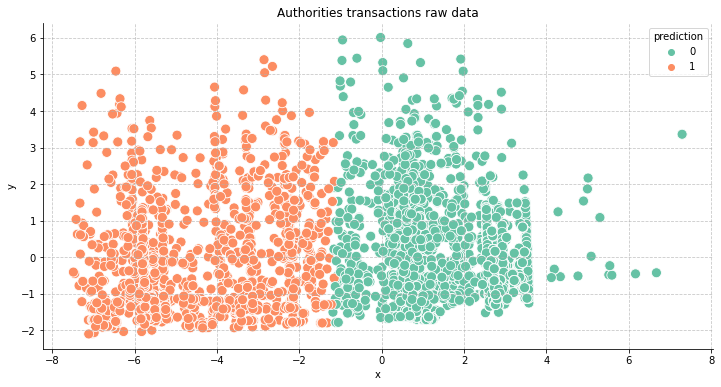

In [95]:
plotting_2D(predictions_kmeans)

In [134]:
kmeans_outliers_indices = get_outliers(model_kmeans,predictions_kmeans,'kmeans')

In [135]:
kmeans_outliers = data_scaled.filter(col("index").isin(kmeans_outliers_indices))

In [185]:
for i in kmeans_outliers.select('scaledFeatures').collect():
  print(i['scaledFeatures'])

[-0.07788520726151435,1.3876880065270356,0.4972821789240427,2.664491571294208,19.127397562744665,0.5716265009909192,0.18749545615497018,0.18850812299443628,0.20759097692313347,-0.030826396508233836,0.4525490380699485,0.32285833065928105,0.16591658316767374,0.11797569412323507,-0.06672573432384901,0.37046849186636444,-0.008952800372129342]
[0.1367587357118775,0.22270136009307925,1.4119559130593171,1.4526963757488458,19.127397562744665,0.5716265009909192,-0.5532327188093061,-0.5560399484980161,-0.7305262354870676,-0.6157634936563007,-0.8441446851600818,-0.8958696937660786,-0.6190195389337393,-0.5172345121342434,-0.5652808438577478,-0.6131189789955558,-0.689883628350916]
[0.1367587357118775,0.22270136009307925,1.4119559130593171,1.4526963757488458,19.127397562744665,0.5716265009909192,-0.5532327188093061,-0.5560399484980161,-0.7305262354870676,-0.6157634936563007,-0.8441446851600818,-0.8958696937660786,-0.6190195389337393,-0.5172345121342434,-0.5652808438577478,-0.6131189789955558,-0.6898

### 5.2. Bisecting k-means

In [96]:
bkm = BisectingKMeans(featuresCol="scaledFeatures")
model_bkm = bkm.fit(data_scaled)

In [97]:
predictions_bkm = model_bkm.transform(data_scaled)

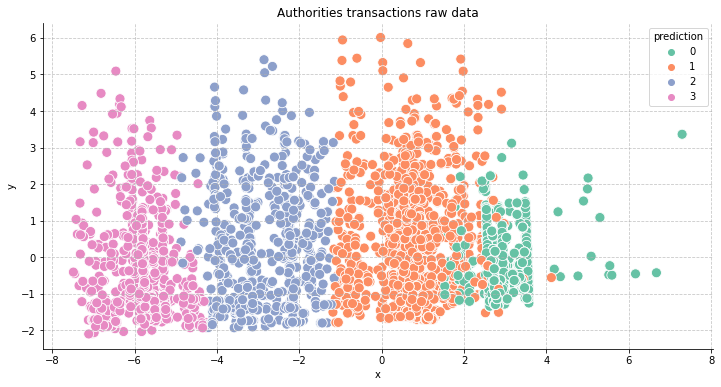

In [98]:
plotting_2D(predictions_bkm)

In [145]:
bkm_outliers_indices = get_outliers(model_bkm,predictions_bkm,'kmeans')

In [146]:
bkm_outliers = data_scaled.filter(col("index").isin(bkm_outliers_indices))

In [186]:
for i in bkm_outliers.select('scaledFeatures').collect():
  print(i['scaledFeatures'])

[-0.07788520726151435,1.3876880065270356,0.4972821789240427,2.664491571294208,19.127397562744665,0.5716265009909192,0.18749545615497018,0.18850812299443628,0.20759097692313347,-0.030826396508233836,0.4525490380699485,0.32285833065928105,0.16591658316767374,0.11797569412323507,-0.06672573432384901,0.37046849186636444,-0.008952800372129342]
[0.1367587357118775,0.22270136009307925,1.4119559130593171,1.4526963757488458,19.127397562744665,0.5716265009909192,-0.5532327188093061,-0.5560399484980161,-0.7305262354870676,-0.6157634936563007,-0.8441446851600818,-0.8958696937660786,-0.6190195389337393,-0.5172345121342434,-0.5652808438577478,-0.6131189789955558,-0.689883628350916]
[0.1367587357118775,0.22270136009307925,1.4119559130593171,1.4526963757488458,19.127397562744665,0.5716265009909192,-0.5532327188093061,-0.5560399484980161,-0.7305262354870676,-0.6157634936563007,-0.8441446851600818,-0.8958696937660786,-0.6190195389337393,-0.5172345121342434,-0.5652808438577478,-0.6131189789955558,-0.6898

### 5.3. Gaussian Mixture Model (GMM)

In [147]:
gmm = GaussianMixture(featuresCol="scaledFeatures",k=3)
model_gmm = gmm.fit(data_scaled)

In [148]:
predictions_gmm = model_gmm.transform(data_scaled)

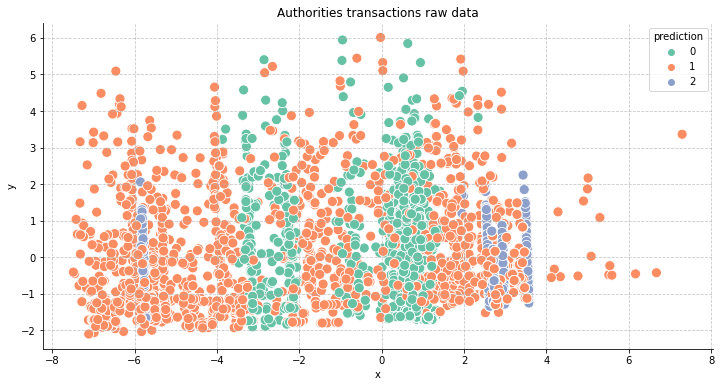

In [149]:
plotting_2D(predictions_gmm)

In [150]:
gmm_outliers_indices = get_outliers(model_gmm,predictions_gmm,'gmm')

In [151]:
gmm_outliers = data_scaled.filter(col("index").isin(gmm_outliers_indices))

In [187]:
for i in gmm_outliers.select('scaledFeatures').collect():
  print(i['scaledFeatures'])

[-0.5071730932082981,1.3876880065270356,-0.2431679868045128,-0.7678707365070532,-0.052270850259306126,-0.7897297046606102,2.230341838564581,2.2908829295300275,2.1778338849261005,1.95561079259989,2.069045553941389,1.7339380235299364,2.225507284792048,2.3292295101046383,1.892187564450767,2.0445867206507984,2.6020818035723106]
[-0.5071730932082981,1.3876880065270356,-0.6351710157196304,-0.8186265562157594,-0.052270850259306126,1.9329827066424483,2.230341838564581,2.2908829295300275,2.1778338849261005,1.95561079259989,2.069045553941389,1.7339380235299364,2.225507284792048,2.3292295101046383,1.892187564450767,2.0445867206507984,2.6020818035723106]
[-0.07788520726151435,0.22270136009307925,2.0217384024828333,0.8372820617807823,-0.052270850259306126,-0.7897297046606102,1.9623203431242093,1.8976220525331624,1.890717610541608,1.9620726193951015,1.7143268564008234,1.7053449919679402,2.028706012810223,1.8065169417126066,2.168483087847509,1.7013473016275618,2.2410399138262895]
[-0.0778852072615143

checking and investigating the outliers

## 6. Result : Suspicious transaction detected

1. kmeans:

    kmeans found a few outliers that we needed to investigating.

    the outliers was points that wasn't behaved in the same patern and had different interesting thoughts.
    some of them shows that some stocks had a huge increasement after a purchase by a senators right after the purchase and some of them shows an increasement after 3 months

2. Bisecting k-means:

  the model shows only transactions as suspicious when it was huge increasement right after the purchase in the stock but not in the long term

3. GMM:

  the model find points as outliers only points that shows increasements in the stocks only for moderate and long term

final thoughts:

  It was huge different between the results of the different models and how they determine which point is an ouliers or not. Although we extract features that help the model to generalise what is considered to be anomaly for short/moderate/long term, it seems like each model focused on his own path.

  It seems like the best way to get the most accurate and general results is to investigate a methods that assemble couple of models or using advanced models of deep learning like cnn/transformers and ect